# 신경망을 통한 Q-러닝

In [2]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
env = gym.make('FrozenLake-v0')

## 네트워크 만들기 

In [4]:
tf.reset_default_graph()

In [5]:
# 액션을 선택하는 데 사용되는 네트워크의 피드포워드 부분
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32) # 상태(원핫)
W = tf.Variable(tf.random_uniform([16,4],0,0.01)) # 가중치가 Q테이블 셀 역할임
Qout = tf.matmul(inputs1,W) 
predict = tf.argmax(Qout,1)

# 타깃Q와 예측Q 값의 차의 제곱합을 구함으로써 비용 얻음
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32) # 타깃Q 
loss = tf.reduce_sum(tf.square(nextQ - Qout)) 
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

## 네트워크 학습

In [7]:
init = tf.global_variables_initializer()

# Set learning parameters
y = .99 # 감마
e = 0.1
num_episodes = 2000

# 보상의 총계와 에피소드별 단계 수를 담을 리스트
jList = [] # 에피소드별 단계 수
rList = [] # 보상의 총계
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        # 환경을 리셋하고 첫번째 새로운 관찰 얻음
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        
        # Q 네트워크
        while j < 99:
            j+=1
            
            # Q 네트워크에서 e의 확률로 랜덤한 액션과 함께 그리디하게 액션 선택
            a, allQ = sess.run([predict, Qout],
                              feed_dict={inputs1:np.identity(16)[s:s+1]})
            
            # 랜덤 액션선택
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
                
            # 환경으로부터 새로운 상태와 보상을 얻는다.
            s1,r,d,_ = env.step(a[0])
            
            # 새로운 상태를 네트워크에 피드해줌으로써 Q'값 계산
            Q1 = sess.run(Qout, 
                          feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            
            # max Q'값 선택. 액션에 대한 타깃값을 설정
            maxQ1 = np.max(Q1)
            
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            
            # 타깃 및 예측Q값을 이용해 네트워크 학습시킴
            _,W1 = sess.run([updateModel,W],
                            feed_dict={inputs1:np.identity(16)[s:s+1],
                                       nextQ:targetQ})
            rAll += r
            s = s1
            
            if d == True:
                # 모델을 학습해나감에 따라 랜덤 액션의 가능성을 줄여줌
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Percent of succesful episodes: 0.4435%


## 네트워크 성능 살펴보기

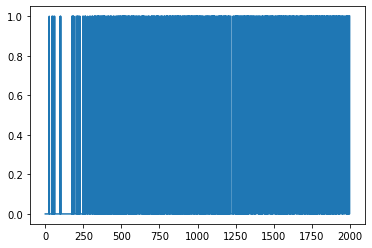

In [8]:
plt.plot(rList)

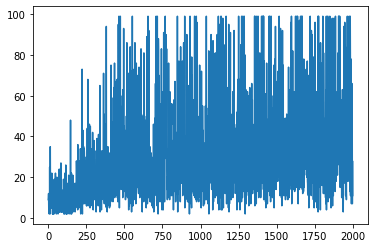

In [9]:
plt.plot(jList)